In [877]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import missingno as msno
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder

In [878]:
os. getcwd()

'/Users/dimitrikestenbaum/Desktop/mbd2021-bank-telemarketing-outcome-prediction/notebooks'

In [879]:
def label_encoder(df,cols):
    """iterates over list of cols
       transforming each col within 
       a dataframe of only categorical columns
       to a numerical value
       args: a dataframe with only categorical features 
       and a list of col names
       output: the df given as input is returned
       with the numerical transformations of each categorical
    """
    for col in cols:
        df[col] = df[col].astype('category').cat.codes
    return(df)

In [880]:
def impute_indicator(df_train,df_test):
    cols_with_missings_train = [col for col in df_train.columns if df_train[col].isnull().sum() > 0]
    
    cols_with_missings_test = [col for col in df_test.columns if df_test[col].isnull().sum() > 0]
    # Create an indicator column for columns that were imputed
    indicators_train = df_train[cols_with_missings_train].isnull().astype(int).add_suffix('_indicator')
    
    indicators_test =  df_test[cols_with_missings_test].isnull().astype(int).add_suffix('_indicator')
    
    df_train = pd.concat([df_train,indicators_train],axis=1)
    df_test = pd.concat([df_test,indicators_test],axis=1)
    
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    

    for col in df_train[cols_with_missings_train].columns:
        if df_train[col].dtype == 'object':
            imp_freq=imp_freq.fit(df_train[[col]])
            df_train[col] = imp_freq.transform(df_train[[col]])
        else:
            imp_mean=imp_mean.fit(df_train[[col]])
            df_train[col] = imp_mean.transform(df_train[[col]])
    
    for col in x_test[cols_with_missings_test].columns:
        if df_test[col].dtype == 'object':
            imp_freq=imp_freq.fit(df_test[[col]])
            df_test[col] = imp_freq.transform(df_test[[col]])
        else:
            imp_mean=imp_mean.fit(df_test[[col]])
            df_test[col] = imp_mean.transform(df_test[[col]])

    return df_train, df_test

In [881]:
#preprocessing
label_encoding = False 
impute_indicate = True
impute_missing = False
one_hot_encoding = True

In [882]:
df_train = pd.read_csv("../data/bank_mkt_train.csv")

In [883]:
df_train.head()

,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,unknown,married,unknown,unknown,unknown,unknown,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


In [884]:
df_test = pd.read_csv("../data/bank_mkt_test.csv")

In [885]:
df_test.head()

,client_id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,2986,53.0,technician,single,professional.course,no,no,no,cellular,jul,tue,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
1,29710,32.0,blue-collar,married,basic.6y,no,yes,no,telephone,jul,wed,2.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
2,38938,70.0,retired,married,high.school,no,yes,no,cellular,aug,tue,1.0,999.0,0.0,nonexistent,-2.9,92.201,-31.4,0.883,5076.2
3,31313,46.0,services,married,high.school,no,no,no,cellular,apr,mon,1.0,999.0,1.0,failure,-1.8,93.075,-47.1,1.405,5099.1
4,24173,35.0,technician,single,unknown,no,no,no,cellular,may,thu,1.0,999.0,1.0,failure,-1.8,92.893,-46.2,1.266,5099.1


In [886]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       20000 non-null  int64  
 1   age             19798 non-null  float64
 2   job             19839 non-null  object 
 3   marital         19801 non-null  object 
 4   education       19830 non-null  object 
 5   default         19786 non-null  object 
 6   housing         19805 non-null  object 
 7   loan            19781 non-null  object 
 8   contact         19783 non-null  object 
 9   month           19801 non-null  object 
 10  day_of_week     19815 non-null  object 
 11  campaign        19797 non-null  float64
 12  pdays           19815 non-null  float64
 13  previous        19791 non-null  float64
 14  poutcome        19825 non-null  object 
 15  emp.var.rate    19835 non-null  float64
 16  cons.price.idx  19819 non-null  float64
 17  cons.conf.idx   19803 non-null 

In [887]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       10000 non-null  int64  
 1   age             9895 non-null   float64
 2   job             9889 non-null   object 
 3   marital         9905 non-null   object 
 4   education       9903 non-null   object 
 5   default         9876 non-null   object 
 6   housing         9897 non-null   object 
 7   loan            9891 non-null   object 
 8   contact         9913 non-null   object 
 9   month           9880 non-null   object 
 10  day_of_week     9894 non-null   object 
 11  campaign        9912 non-null   float64
 12  pdays           9900 non-null   float64
 13  previous        9895 non-null   float64
 14  poutcome        9895 non-null   object 
 15  emp.var.rate    9895 non-null   float64
 16  cons.price.idx  9899 non-null   float64
 17  cons.conf.idx   9896 non-null   

<AxesSubplot:>

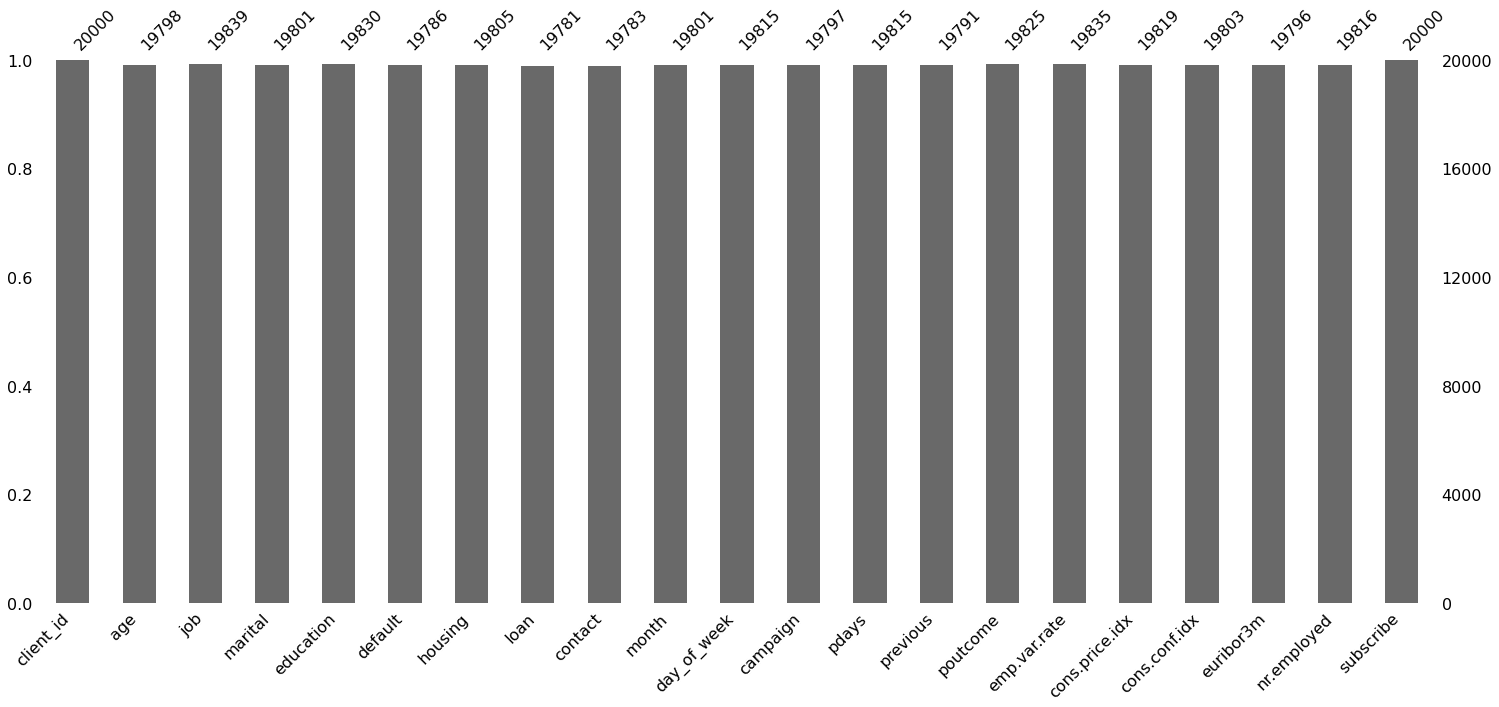

In [888]:
msno.bar(df_train)

<AxesSubplot:>

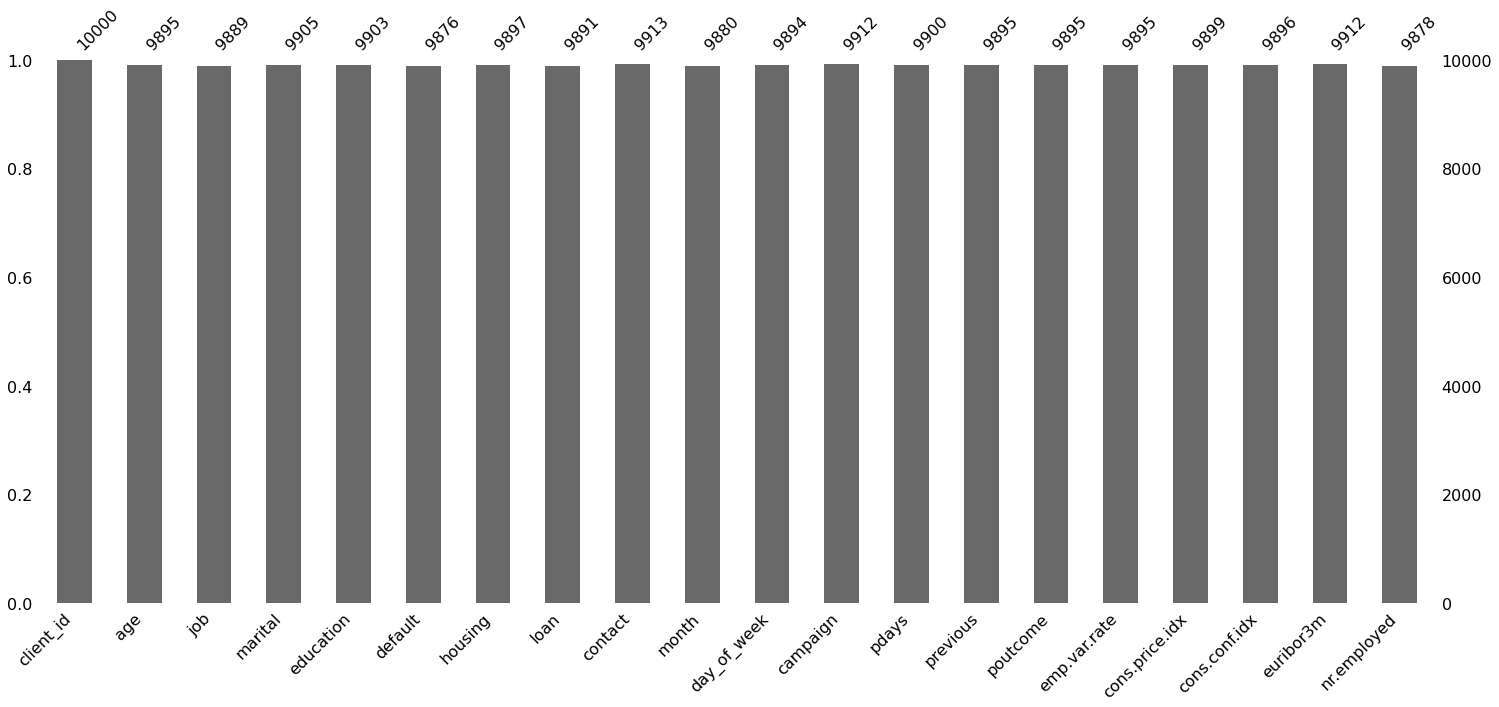

In [889]:
msno.bar(df_test)

## Examine Feature Importance

In [890]:
df_train.columns

Index(['client_id', 'age', 'job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'subscribe'],
      dtype='object')

In [891]:
df_train.dtypes

client_id           int64
age               float64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign          float64
pdays             float64
previous          float64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
subscribe           int64
dtype: object

In [892]:
#cat_cols = []
#numeric_cols = []

#for col in df_train.columns:
#    if df_train[col].dtype == 'object':
#        cat_cols.append(col)
#    else:
#        numeric_cols.append(col)

In [893]:
# List comprehension categoricals
cat_cols = [col for col in df_train.columns if df_train[col].dtype == 'object']

# List comprehension numerics
numeric_cols = [col for col in df_train.columns if col not in cat_cols and col != 'subscribe']

In [894]:
numeric_cols

['client_id',
 'age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

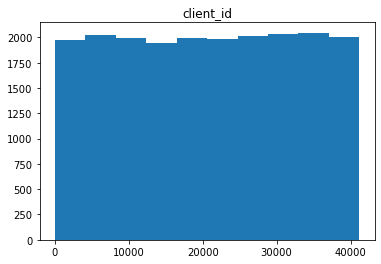

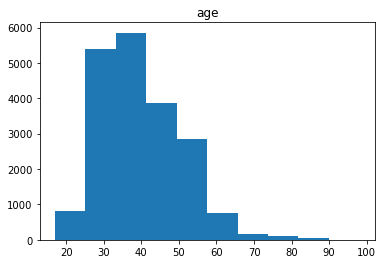

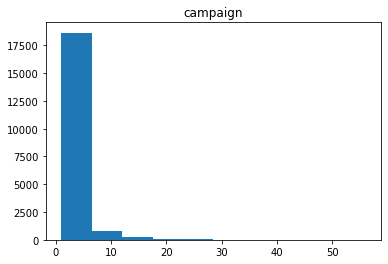

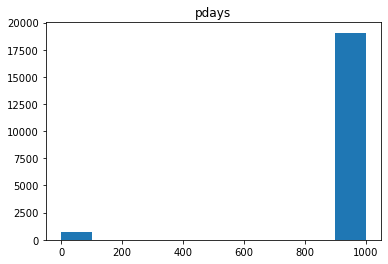

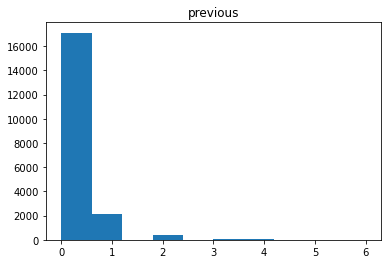

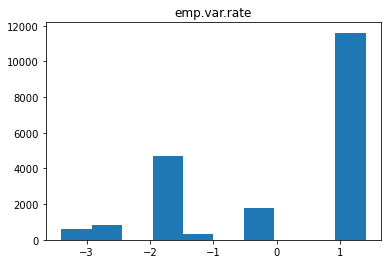

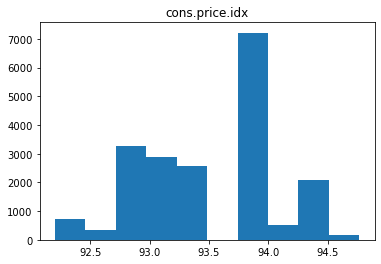

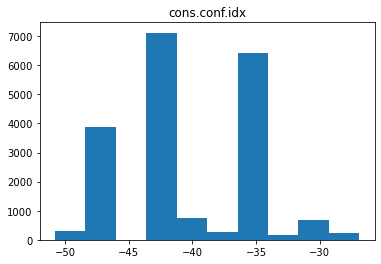

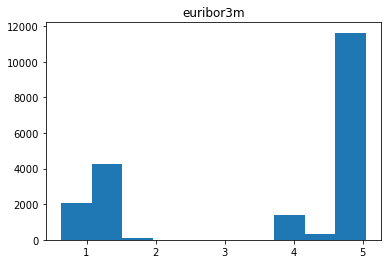

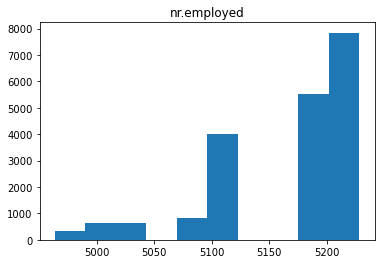

In [895]:
for col in numeric_cols:
    plt.hist(df_train[col])
    plt.title(col)
    plt.show()

In [896]:
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [897]:
numeric_cols

['client_id',
 'age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [898]:
if impute_missing == True:
    print('ran')
    df_train[cat_cols] = df_train[cat_cols].fillna('Missing')
    df_test[cat_cols] = df_test[cat_cols].fillna('Missing')
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean=imp_mean.fit(df_train[numeric_cols])
    df_train[numeric_cols] = imp_mean.transform(df_train[numeric_cols])
    imp_mean=imp_mean.fit(df_test[numeric_cols])
    df_test[numeric_cols] = imp_mean.transform(df_test[numeric_cols])

In [899]:
if label_encoding == True:
    print('ran')
    df_train = label_encoder(df_train,cat_cols)
    df_test = label_encoder(df_test,cat_cols)

In [900]:
if one_hot_encoding == True:
    print('ran')
    #train
    one_hot_encoder = OneHotEncoder(sparse=False)
    train_encoded = one_hot_encoder.fit_transform(df_train[cat_cols])
    train_encoded = pd.DataFrame(train_encoded)
    train_encoded.columns = one_hot_encoder.get_feature_names_out()
    df_train.drop(columns=cat_cols,inplace=True)
    df_train = pd.concat([df_train,train_encoded],axis=1).reset_index()
    #test
    test_encoded = one_hot_encoder.fit_transform(df_test[cat_cols])
    test_encoded = pd.DataFrame(test_encoded)
    test_encoded.columns = one_hot_encoder.get_feature_names_out()
    df_test.drop(columns=cat_cols,inplace=True)
    df_test = pd.concat([df_test,test_encoded],axis=1).reset_index()

ran


In [901]:
df_train.head()

,index,client_id,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,day_of_week_nan,poutcome_failure,poutcome_nonexistent,poutcome_success,poutcome_nan
0,0,29925,42.0,1.0,999.0,0.0,1.4,93.918,-42.7,4.968,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,37529,35.0,4.0,999.0,0.0,1.4,94.465,-41.8,4.960,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,2757,44.0,1.0,999.0,0.0,-1.8,92.893,-46.2,1.264,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,9642,45.0,1.0,999.0,0.0,-1.8,93.075,-47.1,1.453,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,14183,45.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.859,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [902]:
df_test.columns

Index(['index', 'client_id', 'age', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'job_nan', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'marital_nan',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'education_nan', 'default_no', 'default_unknown',
       'default_nan', 'housing_no', 'housing_unknown', 'housing_yes',
       'housing_nan', 'loan_no', 'loan_unknown', 'loan_yes', 'loan_nan',
       'contact_cellular', 'contact_telephone', 'contact_nan', 'month_apr',
     

In [903]:
if impute_indicate == True:
    print('ran')
    df_train, df_test = impute_indicator(df_train,df_test)

ran


In [904]:
X = df_train[[col for col in df_train.columns]]
y = df_train.subscribe

In [905]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

In [906]:
clf.fit(X_train,y_train)

preds = clf.predict(X_test)

In [907]:
accuracy_score(y_test, preds)

1.0

### preprocessing for entire train and test sets

In [908]:
df_train.subscribe.value_counts()

0    17729
1     2271
Name: subscribe, dtype: int64

## Imputation

In [909]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          20000 non-null  int64  
 1   client_id                      20000 non-null  int64  
 2   age                            20000 non-null  float64
 3   campaign                       20000 non-null  float64
 4   pdays                          20000 non-null  float64
 5   previous                       20000 non-null  float64
 6   emp.var.rate                   20000 non-null  float64
 7   cons.price.idx                 20000 non-null  float64
 8   cons.conf.idx                  20000 non-null  float64
 9   euribor3m                      20000 non-null  float64
 10  nr.employed                    20000 non-null  float64
 11  subscribe                      20000 non-null  int64  
 12  job_admin.                     20000 non-null 

In [910]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 82 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          10000 non-null  int64  
 1   client_id                      10000 non-null  int64  
 2   age                            10000 non-null  float64
 3   campaign                       10000 non-null  float64
 4   pdays                          10000 non-null  float64
 5   previous                       10000 non-null  float64
 6   emp.var.rate                   10000 non-null  float64
 7   cons.price.idx                 10000 non-null  float64
 8   cons.conf.idx                  10000 non-null  float64
 9   euribor3m                      10000 non-null  float64
 10  nr.employed                    10000 non-null  float64
 11  job_admin.                     10000 non-null  float64
 12  job_blue-collar                10000 non-null  

In [911]:
#subset train set for important cols based on correlation analysis 
X_train = df_train[[col for col in df_train.columns if col != 'subscribe']]

In [912]:
#test set as well - dv subscribe
X_test = df_test[[col for col in df_test.columns]]

In [913]:
#seperate feature matrix and target vector
#X_train = df_train[['client_id', 'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       #'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed','job', 'marital', 'education', 'default', 'housing',
       #'loan', 'contact', 'month', 'day_of_week', 'poutcome']]
y_train = df_train.subscribe

In [914]:
#create X_test matrix 
#seperate feature matrix and target vector
#X_test = df_test[['client_id', 'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       #'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed','job', 'marital', 'education', 'default', 'housing',
       #'loan', 'contact', 'month', 'day_of_week', 'poutcome']]


In [220]:
rf = RandomForestClassifier()
# create parameter dictionary 
param_grid = {'bootstrap': [True, False],
                'max_depth': [int(x) for x in np.linspace(10, 110, num = 20)],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 4, 6, 10],
                'min_samples_split': [5, 10, 15, 20, 25],
                'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 3000, num = 20)]}
#initiate grid search
grid = RandomizedSearchCV(rf,param_grid,
                          n_iter=100,
                          random_state=123,
                          verbose=3,
                          cv=3)
#fit train data

grid.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=True, max_depth=88, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=863;, score=0.899 total time=  10.8s
[CV 2/3] END bootstrap=True, max_depth=88, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=863;, score=0.900 total time=  11.2s
[CV 3/3] END bootstrap=True, max_depth=88, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=863;, score=0.904 total time=  11.0s
[CV 1/3] END bootstrap=False, max_depth=52, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1626;, score=0.896 total time=  31.5s
[CV 2/3] END bootstrap=False, max_depth=52, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1626;, score=0.899 total time=  32.1s
[CV 3/3] END bootstrap=False, max_depth=52, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1626;, score=0.899 total time=  33.1s
[CV 1/3

[CV 3/3] END bootstrap=True, max_depth=83, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=710;, score=0.903 total time=   9.1s
[CV 1/3] END bootstrap=True, max_depth=99, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=2542;, score=0.899 total time=  28.9s
[CV 2/3] END bootstrap=True, max_depth=99, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=2542;, score=0.901 total time=  29.9s
[CV 3/3] END bootstrap=True, max_depth=99, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=2542;, score=0.904 total time=  32.0s
[CV 1/3] END bootstrap=True, max_depth=46, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=863;, score=0.899 total time=  10.0s
[CV 2/3] END bootstrap=True, max_depth=46, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=863;, score=0.901 total time=  10.0s
[CV 3/3] END bootstrap=True, max_depth=46, max_features=sqrt, min_s

[CV 2/3] END bootstrap=False, max_depth=62, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1168;, score=0.898 total time=  23.2s
[CV 3/3] END bootstrap=False, max_depth=62, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1168;, score=0.900 total time=  23.3s
[CV 1/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=2847;, score=0.899 total time=  34.9s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=2847;, score=0.900 total time=  33.6s
[CV 3/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=2847;, score=0.904 total time=  34.5s
[CV 1/3] END bootstrap=True, max_depth=94, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=1931;, score=0.899 total time=  21.9s
[CV 2/3] END bootstrap=True, max_depth=94, max_features=sqrt, min_sam

[CV 1/3] END bootstrap=True, max_depth=62, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=100;, score=0.898 total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=62, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=100;, score=0.901 total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=62, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=100;, score=0.903 total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=2542;, score=0.900 total time=  31.5s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=2542;, score=0.900 total time=  31.5s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=2542;, score=0.905 total time=  30.6s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_sample

[CV 3/3] END bootstrap=False, max_depth=41, max_features=sqrt, min_samples_leaf=1, min_samples_split=25, n_estimators=1168;, score=0.903 total time=  20.7s
[CV 1/3] END bootstrap=True, max_depth=52, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2236;, score=0.898 total time=  28.4s
[CV 2/3] END bootstrap=True, max_depth=52, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2236;, score=0.899 total time=  29.2s
[CV 3/3] END bootstrap=True, max_depth=52, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2236;, score=0.903 total time=  29.2s
[CV 1/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=252;, score=0.899 total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=252;, score=0.900 total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_sampl

[CV 2/3] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=25, n_estimators=2847;, score=0.900 total time=  35.1s
[CV 3/3] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=25, n_estimators=2847;, score=0.903 total time=  34.7s
[CV 1/3] END bootstrap=False, max_depth=36, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=557;, score=0.900 total time=   9.4s
[CV 2/3] END bootstrap=False, max_depth=36, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=557;, score=0.899 total time=   9.0s
[CV 3/3] END bootstrap=False, max_depth=36, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=557;, score=0.903 total time=   9.2s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=25, n_estimators=710;, score=0.899 total time=   8.1s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=auto, mi

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 20, 25, 31, 36,
                                                      41, 46, 52, 57, 62, 67,
                                                      73, 78, 83, 88, 94, 99,
                                                      104, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 10],
                                        'min_samples_split': [5, 10, 15, 20,
                                                              25],
                                        'n_estimators': [100, 252, 405, 557,
                                                         710, 863, 1015, 1168,
                                                         1321, 1473, 1626, 1778,
                           

In [627]:
print(grid.best_params_)
print(grid.best_estimator_)

{'n_estimators': 557, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=20, n_estimators=557)


In [915]:
list(set(X_train.columns) - set( X_test.columns))

['default_yes']

In [916]:
X_train.drop(columns=['default_yes'],inplace=True)

/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


{'n_estimators': 733,
 'min_samples_split': 20,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

{'n_estimators': 557, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=20, n_estimators=557)

In [917]:
clf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=6, min_samples_split=20, n_estimators=557,random_state=123)

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=20, n_estimators=557,
                       random_state=123)

In [918]:
feature_importances = clf.feature_importances_

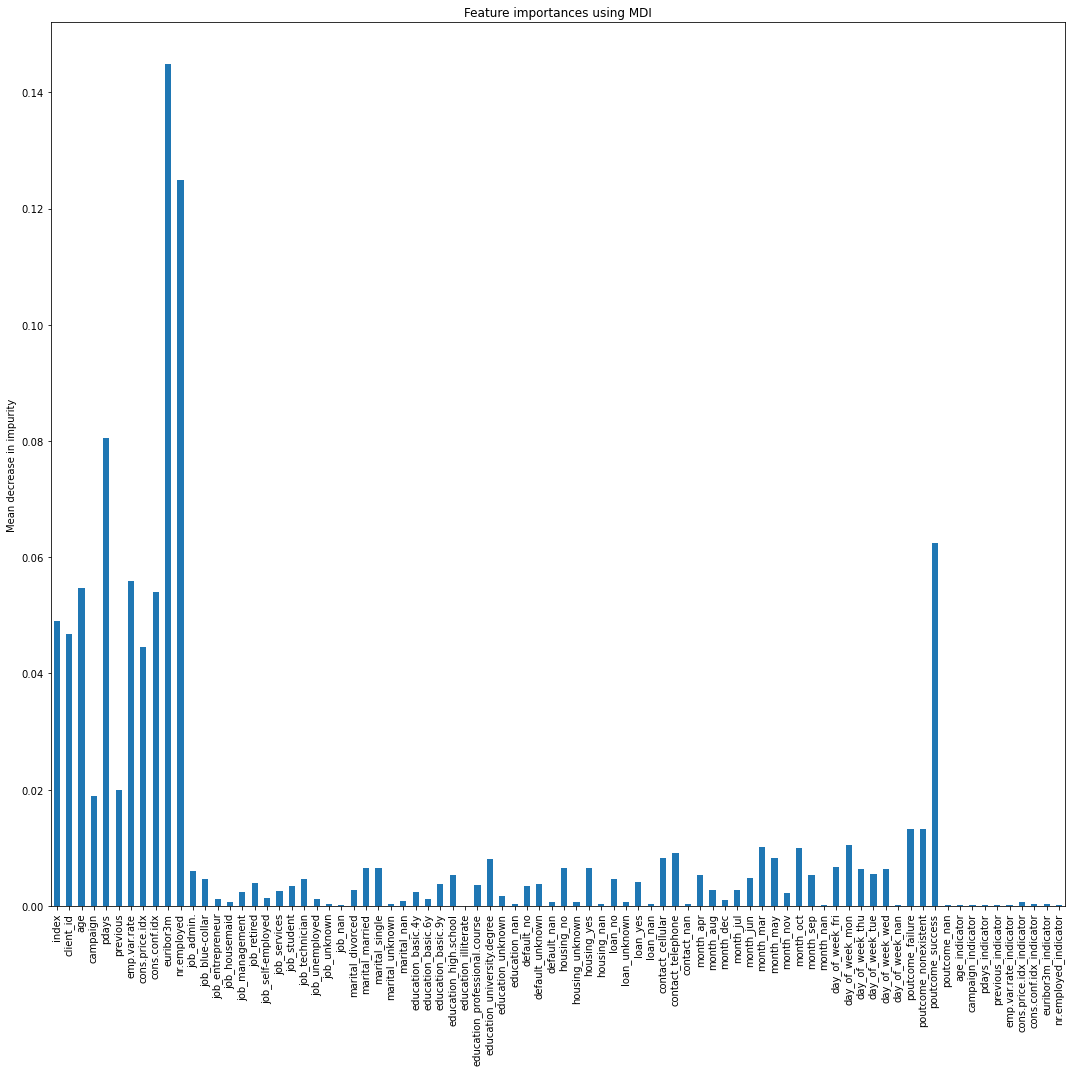

In [919]:
forest_importances = pd.Series(feature_importances, index=X_train.columns.to_list())

fig, ax = plt.subplots(figsize=(15,15))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
rf_preds = clf.predict_proba(X_test)[:,1]

In [ ]:
final_df = X_test.copy(deep=True)
final_df = X_test[['client_id']]
final_df['subscribe'] = rf_preds

In [ ]:
final_df.client_id = final_df.client_id.astype('int')

In [ ]:
final_df.head()

In [ ]:
final_df.to_csv('rf_submission10.csv',index=False)